In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvnorm
from numpy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

import pdb, time

seed = 0
np.random.seed(seed)

### Import and generate data

In [2]:
# Standardised Fama French 5 to industry portfolio 30
# Import data
data = pd.read_pickle("/Users/sikai/Downloads/ff5_30_nonsmooth_standard_4000_draws.pkl")

# # Restrict to 100 time points
X = data[10:110].transpose(2, 1, 0)
X_cov = np.einsum('ijkl,jmkl->imkl', np.expand_dims(X, 1), np.expand_dims(X, 0))

### Train

In [18]:
n_dimensions, _, n_samples, time_steps = X_cov.shape
emp_inv = []
for i in range(time_steps):
    emp_inv.append(np.linalg.inv(np.mean(X_cov[:, :, :, i], 2)))
emp_inv = np.array(emp_inv)

In [32]:
from regain.covariance import GradientEqualTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl_g = GradientEqualTimeGraphicalLasso(max_iter=10000, loss='LL', c_level=0.2, theta=0.5, rho=1e3, mult=2, weights=None, m=100, eps=2, psi="laplacian")
emp_inv_score_g, baseline_score_g, fit_score_g, pre_g = tgl_g.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))
# min_pre_tp = np.amin(np.abs(pre_tp[pre_tp != 0]))

ImportError: cannot import name 'NewGradientEqualTimeGraphicalLasso' from 'regain.covariance' (/Users/sikai/Dropbox/Research/post_sum/code/regain/regain/covariance/__init__.py)

In [31]:
from regain.covariance import TaylorEqualTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl_tp = TaylorEqualTimeGraphicalLasso(max_iter=10000, loss='LL', c_level=0.2, theta=0.5, rho=1e3, mult=2, weights=None, m=100, eps=2, psi="laplacian")
emp_inv_score_tp, baseline_score_tp, fit_score_tp, pre_tp = tgl_tp.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))
# min_pre_tp = np.amin(np.abs(pre_tp[pre_tp != 0]))

0
-6.883266595201455 -7.762712513025564
51013.43174175849


/Users/sikai/.pyenv/versions/3.7.6/lib/python3.7/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


100
3.966445616399028e-09 1.5131939923307413e-10
46810.97433066941
200
6.6325540615252976e-09 2.985336933214455e-10
43722.056976910215
300
2.8943624386101874e-08 5.841877892542869e-10
41231.75896962495
400
7.101030377043571e-07 7.726715780531635e-09
39168.77158181912
500
2.5815812132456983e-07 3.5048664570602738e-09
37415.18836524658
600
4.0513774912653844e-07 5.048816633657083e-09
35888.3665136504
700
2.9275380519777627e-07 4.269234297193946e-09
34531.419527064296
800
4.311022525627095e-07 9.314206452781804e-09
33305.18490373203
900
6.837957755578827e-08 2.5255973112869866e-09
32183.176878352046
1000
1.0366018710072922e-07 3.837357398506214e-09
31145.223995497807
1100
5.2749156154163757e-08 2.4370379647642436e-09
30178.197352265826
1200
2.5027818040257443e-08 1.7057070222925574e-09
29272.584826576596
1300
2.1325024412988114e-08 -7.418520500677151e-06
28419.26816462755
1400
0.18854051426444052 0.0018849082563907316
27612.184799537466
1500
0.6222826511707868 0.0062242723622972715
26845.

/Users/sikai/Dropbox/Research/post_sum/code/regain/regain/covariance/taylor_equal_time_graphical_lasso.py:381: UserWarning: Objective did not converge.
  covariance_ = np.array([linalg.pinvh(x) for x in Z_0])


In [23]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl_g.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre_g_thres = {}
fit_score_g_thres = {}
for i in [1e-4, 1e-6, 0]:
    pre_g_thres[i] = np.array([k * (np.abs(k) >= i) for k in pre_g])
    tgl_g.precision_ = pre_g_thres[i]
    emp_inv_score, baseline_score, fit_score_g_thres[i], _ = tgl_g.eval_cov_pre() 
    print(penalty_objective(pre_g_thres[i], pre_g_thres[i][:-1], pre_g_thres[i][1:], psi, tgl_g.theta))

14195.524610111383
14195.528237904382
14195.528241815833


In [ ]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl_tp.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre_tp_thres = {}
fit_score_tp_thres = {}
for i in [1e-4, 1e-6, 0]:
    pre_tp_thres[i] = np.array([k * (np.abs(k) >= i) for k in pre_tp])
    tgl_tp.precision_ = pre_tp_thres[i]
    emp_inv_score, baseline_score, fit_score_tp_thres[i], _ = tgl_tp.eval_cov_pre() 
    print(penalty_objective(pre_tp_thres[i], pre_tp_thres[i][:-1], pre_tp_thres[i][1:], psi, tgl_tp.theta))

In [12]:
from regain.covariance import CVXInequalityTimeGraphicalLasso, TimeGraphicalLasso
pre_cvx = np.load("mosek_sol_ff5_30_standard_alpha_0.2.npy")

In [13]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl_g.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre = {}
fit_score = {}
# for i in [1e-2, 1e-3, 1e-4, 1e-6]:
for i in [1e-4]:
    pre[i] = np.array([k * (np.abs(k) >= i) for k in pre_cvx])
    tgl_g.precision_ = pre[i]
    emp_inv_score, baseline_score, fit_score[i], _ = tgl_g.eval_cov_pre() 
    print(penalty_objective(pre[i], pre[i][:-1], pre[i][1:], psi, tgl_g.theta))

5951.380304945549


In [14]:
tgl = TimeGraphicalLasso(alpha=1., beta=1., mode='admm', rho=1, tol=1e-4,
            rtol=1e-4, psi='laplacian', max_iter=3000, verbose=False, assume_centered=False, 
            return_history=False, update_rho_options=None, compute_objective=True, 
            stop_at=None, stop_when=1e-4, suppress_warn_list=False, init='empirical')
fit_score_, pre_ = tgl.fit_cov(X_cov).eval_cov_pre()   

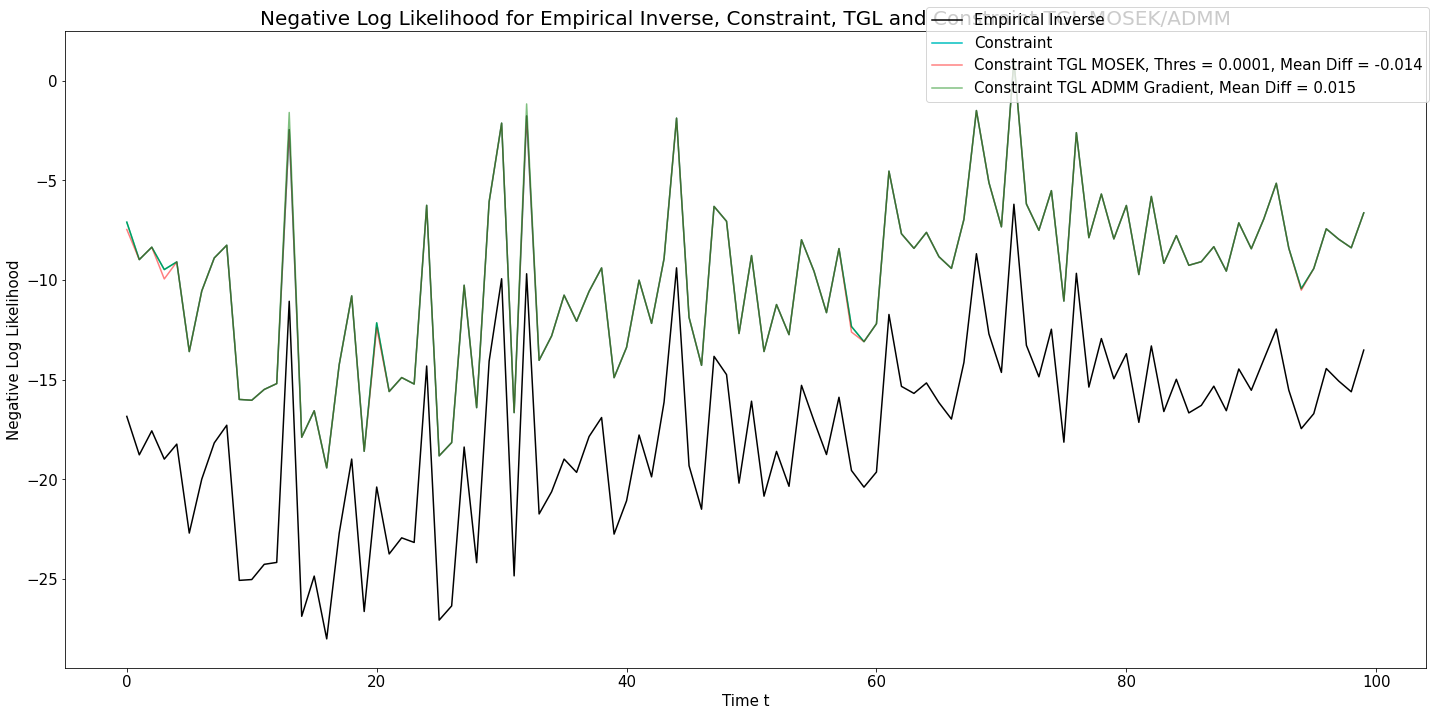

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(X_cov.shape[-1]), emp_inv_score_g, color='k', label=r'Empirical Inverse')
ax.plot(range(X_cov.shape[-1]), baseline_score_g, color='c', label=r'Constraint')
for i in [1e-4]:
    mean_diff = np.mean(np.array(fit_score[i]) - baseline_score)
    ax.plot(range(X_cov.shape[-1]), fit_score[i], color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), fit_score[i], color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# mean_diff = np.mean(np.array(fit_score_grad) - baseline_score_grad)
# ax.plot(range(X_cov.shape[-1]), fit_score_grad, alpha=0.5, color='m',
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(mean_diff))
# mean_diff = np.mean(np.array(fit_score_tp) - baseline_score_tp)
mean_diff = np.mean(np.array(fit_score_g_thres[1e-4]) - baseline_score_g)
# ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
ax.plot(range(X_cov.shape[-1]), fit_score_g_thres[1e-4], alpha=0.5, color='g',
        label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(mean_diff))
# mean_diff = np.mean(np.array(fit_score_tp_thres[1e-4]) - baseline_score_g)
# # ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
# ax.plot(range(X_cov.shape[-1]), fit_score_tp_thres[1e-4], alpha=0.5, color='m',
#         label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(mean_diff))

# mean_diff = np.mean(np.array(fit_score_) - res[1][1])
# ax.plot(range(X_cov.shape[-1]), fit_score_, color='y', label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(mean_diff))

fig.legend(fontsize=15)
ax.set_ylabel('Negative Log Likelihood', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Negative Log Likelihood for Empirical Inverse, Constraint, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('ff5_ip30_10000_diff_like_indiv.pdf')

In [16]:
np.log(np.array(fit_score_g_thres[1e-4]) - baseline_score_g)

/Users/sikai/.pyenv/versions/3.7.6/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


array([-1.87826663e+01, -2.17057081e+01, -1.57409405e+01, -1.87767518e+01,
       -1.04084684e+01, -2.30962150e+01, -1.13855735e+01, -1.34378108e+01,
       -1.02970637e+01, -2.39527672e+01, -1.08785279e+01, -2.06710733e+01,
       -2.22324320e+01,  3.32289243e-03,             nan, -1.16747762e+01,
                   nan, -1.39548670e+01, -1.36278257e+01, -2.65965033e+01,
       -1.25916542e+01, -2.34622450e+01, -1.61935457e+01, -1.74856217e+01,
       -6.83721029e+00,             nan, -2.50718753e+01, -9.79947179e+00,
       -2.22313801e+01, -1.74071480e+01, -1.15951048e+01,             nan,
        6.26396115e-01, -1.92762964e+01, -1.03201996e+01, -2.42550982e+01,
       -1.61638416e+01, -1.38720155e+01, -1.04278384e+01,             nan,
       -1.22431443e+01, -1.50616746e+01, -2.22049733e+01, -1.26316631e+01,
       -1.68970242e+01, -2.16775736e+01,             nan, -9.44621558e+00,
       -1.17818547e+01, -2.48055859e+01, -1.74518076e+01, -1.07527540e+01,
       -1.00640175e+01, -

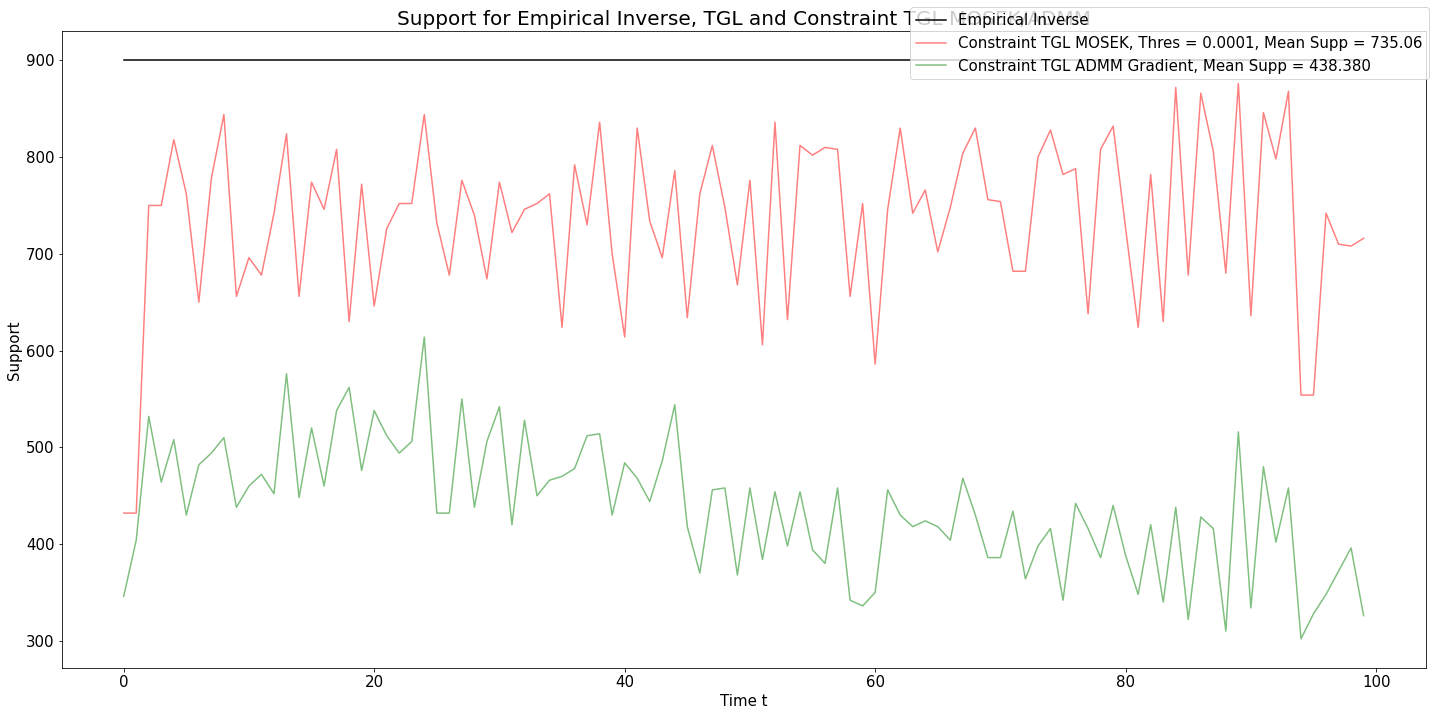

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0

ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(emp_inv[k]) > 0)) for k in range(X_cov.shape[-1])], 
        color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    supp = [sum(sum(abs(pre[i][t]) > 0)) for t in range(X_cov.shape[-1])]
    mean_supp = np.mean(supp)
    ax.plot(range(X_cov.shape[-1]), supp, color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), supp, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Supp = {}'.format(i, mean_supp))
    color_index += 1
# supp = [sum(sum(abs(pre_grad[t]) > 0)) for t in range(X_cov.shape[-1])]
# ax.plot(range(X_cov.shape[-1]), supp, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_g_thres[1e-4][t]) > 0)) for t in range(X_cov.shape[-1])]
# supp = [sum(sum(abs(pre_tp[t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), supp, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Gradient, Mean Supp = {:.3f}'.format(np.mean(supp)))
# supp = [sum(sum(abs(pre_tp_thres[1e-4][t]) > 0)) for t in range(X_cov.shape[-1])]
# supp = [sum(sum(abs(pre_tp[t]) > 0)) for t in range(X_cov.shape[-1])]
# ax.plot(range(X_cov.shape[-1]), supp, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Linear, Mean Supp = {:.3f}'.format(np.mean(supp)))
# supp = [sum(sum(abs(pre_[t]) > 0)) for t in range(X_cov.shape[-1])]
# ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(pre_[k]) > 0)) for k in range(X_cov.shape[-1])], 
#         color='y', label=r'Vanilla TGL, , Mean Supp = {:.3f}'.format(np.mean(supp)))


fig.legend(fontsize=15)
ax.set_ylabel('Support', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Support for Empirical Inverse, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('ff5_ip30_10000_diff_supp_indiv.pdf')

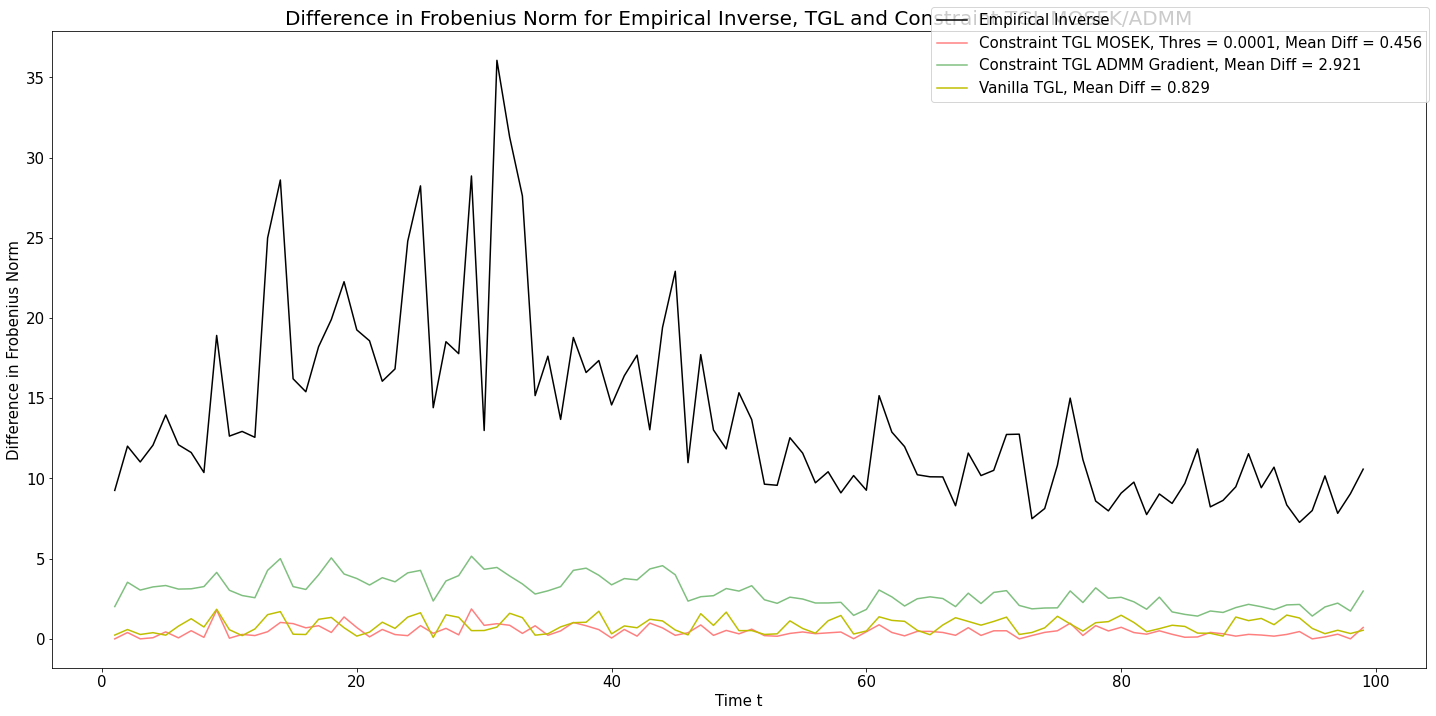

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0

diff_emp = [norm(emp_inv[t] - emp_inv[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_emp), alpha=1, color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    diff = [norm(pre[i][t] - pre[i][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
    mean_diff = np.mean(diff)
    ax.plot(range(1, X_cov.shape[-1]), diff, color='r', alpha=0.5, 
#     ax.plot(range(1, X_cov.shape[-1]), diff, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# diff_grad = [norm(pre_grad[t] - pre_grad[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [norm(pre_g_thres[1e-4][t] - pre_g_thres[1e-4][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# diff_grad = [norm(pre_tp[t] - pre_tp[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
# diff_grad = [norm(pre_tp_thres[1e-4][t] - pre_tp_thres[1e-4][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# # diff_grad = [norm(pre_tp[t] - pre_tp[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_fit_ = [norm(pre_[t] - pre_[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_fit_), color='y', alpha=1, 
        label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(np.mean(diff_fit_)))

fig.legend(fontsize=15)
ax.set_ylabel('Difference in Frobenius Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('ff5_ip30_10000_diff_fro_indiv.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0

diff_emp = [np.sum(norm(emp_inv[t] - emp_inv[t-1], axis=1)) for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_emp), alpha=1, color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    diff = [np.sum(norm(pre[i][t] - pre[i][t-1], axis=1)) for t in range(1, X_cov.shape[-1])]
    mean_diff = np.mean(diff)
    ax.plot(range(1, X_cov.shape[-1]), diff, color='r', alpha=0.5, 
#     ax.plot(range(1, X_cov.shape[-1]), diff, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# diff_grad = [norm(pre_grad[t] - pre_grad[t-1], axis=1) for t in range(1, X_cov.shape[-1])]
# ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [np.sum(norm(pre_g_thres[1e-4][t] - pre_g_thres[1e-4][t-1], axis=1)) for t in range(1, X_cov.shape[-1])]
# diff_grad = [norm(pre_tp[t] - pre_tp[t-1], axis=1) for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [np.sum(norm(pre_tp_thres[1e-4][t] - pre_tp_thres[1e-4][t-1], axis=1)) for t in range(1, X_cov.shape[-1])]
# diff_grad = [norm(pre_tp[t] - pre_tp[t-1], axis=1) for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
        label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_fit_ = [np.sum(norm(pre_[t] - pre_[t-1], axis=1)) for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_fit_), color='y', alpha=1, 
        label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(np.mean(diff_fit_)))

fig.legend(fontsize=15)
ax.set_ylabel('Difference in L2 Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in L2 Norm for Empirical Inverse, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
plt.tight_layout()
# plt.savefig('ff5_ip30_40000_diff_fro_max_2_mult_3_div_5.pdf')